# CANSigLyzer

In this notebook, we extract and select features from CAN-MIRGU, which is a dataset of raw CAN frames collected from a single vehicle by [Rajapaksha et al. (2024)](https://www.ndss-symposium.org/ndss-paper/auto-draft-482/).

**Data**: The dataset used is [CAN-MIRGU](https://github.com/sampathrajapaksha/CAN-MIRGU), which contains both benign and attack data from an unknown 2016 vehicle model. It is a fully electric vehicle with full autonomous driving capabilities. 

**DBC**: We use a DBC obtained from [opendbc](https://github.com/commaai/opendbc), which is an open-source repository of reverse-engineered DBC files contributed by car hacking enthusiasts. 

The paper does not reveal the exact model of the test vehicle, except for the aforementioned details. Apart from this, the AIDs and some associated signals (from the dataset and attack metadata) are known and a [video](https://www.youtube.com/watch?v=CufiACr2Zs8) of the attacks being conducted while the car is being driven is available. However, the car is most likely a Kia since the interior of the test car is a visual match for Kia car interiors from 2016 and we find all the AIDs used in the attacks in the [hyundai_kia_generic.dbc](https://github.com/commaai/opendbc/blob/master/opendbc/dbc/hyundai_kia_generic.dbc) file. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import os
import cantools
from importlib import reload
from tqdm import tqdm

import helper_functions
from helper_functions import *
import gc

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.feature_selection import mutual_info_classif, f_classif, VarianceThreshold
from matplotlib_venn import venn3

In [2]:
# Create DataFrame for summary stats
summary_stats = pd.DataFrame(columns=['Log', 'Type', 'Real/Simulated', 'No. of benign frames', 'No. of attack frames', 'Total no. of frames', 'Total duration', 'Start timestamp', 'End timestamp'])

In [3]:
# Read in benign files
dfs_benign = {}                             # List of all preprocessed benign logs

print("Reading benign files..")
for i in tqdm(range(1, 7)):
    fpath = "CAN-MIRGU/Benign/Day_" + str(i) + "/"
    for lname in os.listdir(fpath):
        # print(lname)
        df = pd.read_csv(fpath + lname)     # Read in log
        df = preprocessDataset(df)          # Preprocess into tabular form
        df['attack_class'] = '0'              # Add attack class column      
        dfs_benign[lname] = df              # Append to list of benign logs

        duration = df.timestamp[len(df) - 1] - df.timestamp[0]
        summary_stats = pd.concat([summary_stats if not summary_stats.empty else None, pd.DataFrame([[lname, 'Benign', 'Real', len(df), 0, len(df), duration, df.timestamp[0], df.timestamp[len(df) - 1]]], columns=summary_stats.columns)], ignore_index=True)

# Save list of benign log names
benign_lnames = list(dfs_benign.keys())

Reading benign files..


100%|██████████| 6/6 [15:47<00:00, 157.85s/it]


In [4]:
# Read in real attack files
dfs_attack = {}

fpath = "CAN-MIRGU/Attack/Real_attacks/"
attack_lnames = list(os.listdir(fpath))

print("Reading real attack files..")
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    # print(lname)
    df = pd.read_csv(fpath + lname)     # Read in log
    df = preprocessDataset(df)          # Preprocess into tabular form
    df['attack_class'] = 0              # Add attack class column
    dfs_attack[lname] = df              # Append to list of attack logs  

    benign_frames = len(df[df.attack == '0'])
    duration = df.timestamp[len(df) - 1] - df.timestamp[0]
    summary_stats = pd.concat([summary_stats, pd.DataFrame([[lname, 'Attack', 'Real', benign_frames, len(df)-benign_frames, len(df), duration, df.timestamp[0], df.timestamp[len(df) - 1]]], columns=summary_stats.columns)], ignore_index=True)

# Save list of attack log names
attack_lnames = list(dfs_attack.keys())

with open('attack_lnames', 'wb') as fp:
    pickle.dump(attack_lnames, fp)

Reading real attack files..


100%|██████████| 26/26 [02:45<00:00,  6.36s/it]


In [5]:
# Read in simulated attack files

dfs_simulated_attack = {}

# Suspension attacks
fpath = "CAN-MIRGU/Attack/Suspension_attacks/"
simulated_attack_lnames = list(os.listdir(fpath))

print("Reading suspension attack files..")
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    df = pd.read_csv(fpath + lname)     # Read in log
    df = preprocessDataset(df)          # Preprocess into tabular form
    df['attack_class'] = '0'             # Add attack class column
    dfs_simulated_attack[lname] = df    # Append to list of attack logs  

    benign_frames = len(df[df.attack == '0'])
    duration = df.timestamp[len(df) - 1] - df.timestamp[0]
    summary_stats = pd.concat([summary_stats, pd.DataFrame([[lname, 'Attack', 'Simulated', benign_frames, len(df)-benign_frames, len(df), duration, df.timestamp[0], df.timestamp[len(df) - 1]]], columns=summary_stats.columns)], ignore_index=True)

# Masquerade attacks
fpath = "CAN-MIRGU/Attack/Masquerade_attacks/"   
simulated_attack_lnames = list(os.listdir(fpath))

print("Reading masquerade attack files..")
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    df = pd.read_csv(fpath + lname)     # Read in log
    df = preprocessDataset(df)          # Preprocess into tabular form
    df['attack_class'] = '0'              # Add attack class column
    dfs_simulated_attack[lname] = df    # Append to list of attack logs  

    benign_frames = len(df[df.attack == '0'])
    duration = df.timestamp[len(df) - 1] - df.timestamp[0]
    summary_stats = pd.concat([summary_stats, pd.DataFrame([[lname, 'Attack', 'Simulated', benign_frames, len(df)-benign_frames, len(df), duration, df.timestamp[0], df.timestamp[len(df) - 1]]], columns=summary_stats.columns)], ignore_index=True)

simulated_attack_lnames = list(dfs_simulated_attack.keys())   # Save list of attack log names


Reading suspension attack files..


100%|██████████| 5/5 [00:45<00:00,  9.14s/it]


Reading masquerade attack files..


100%|██████████| 5/5 [00:28<00:00,  5.72s/it]


In [6]:
# Print summary stats
print("Summary stats for all logs")
print("--------------------------")
display(summary_stats)      # Per log
summary_stats.to_csv("summary_stats.csv", index=False, index_label=False)
print("No. of benign logs         =", len(dfs_benign))
print("No. of attack logs         =", len(dfs_attack))
print()
print("Total no. of benign frames =", sum(summary_stats['No. of benign frames']))
print("Total no. of attack frames =", sum(summary_stats['No. of attack frames']))
print("Total no. of frames        =", sum(summary_stats['Total no. of frames']))
print()

# Real attacks only
print("Summary for real attack logs")
print("----------------------------")
print("No. of real attack logs    =", len(summary_stats[summary_stats['Real/Simulated'] == 'Real']))
print()
print("Total no. of benign frames =", (summary_stats[summary_stats['Real/Simulated'] == 'Real'])['No. of benign frames'].sum())
print("Total no. of attack frames =", (summary_stats[summary_stats['Real/Simulated'] == 'Real'])['No. of attack frames'].sum())
print("Total no. of frames        =", (summary_stats[summary_stats['Real/Simulated'] == 'Real'])['Total no. of frames'].sum())

Summary stats for all logs
--------------------------


,Log,Type,Real/Simulated,No. of benign frames,No. of attack frames,Total no. of frames,Total duration,Start timestamp,End timestamp
0,Benign_day1_file5.log,Benign,Real,6999999,0,6999999,4044.501640,1.683201e+09,1.683205e+09
1,Benign_day1_file2.log,Benign,Real,9999999,0,9999999,5336.978263,1.683284e+09,1.683289e+09
2,Benign_day1_file4.log,Benign,Real,9999999,0,9999999,6547.444097,1.683195e+09,1.683201e+09
3,Benign_day1_file1.log,Benign,Real,9999999,0,9999999,5281.843053,1.683278e+09,1.683284e+09
4,Benign_day1_file3.log,Benign,Real,8494994,0,8494994,4574.537433,1.683289e+09,1.683294e+09
5,Benign_day1_file6.log,Benign,Real,589704,0,589704,374.078034,1.683207e+09,1.683207e+09
6,Benign_day2_file2.log,Benign,Real,10094090,0,10094090,5915.961849,1.683803e+09,1.683809e+09
7,Benign_day2_file1.log,Benign,Real,10109999,0,10109999,5305.112449,1.683798e+09,1.683803e+09
8,Benign_day3_file1.log,Benign,Real,9807444,0,9807444,5170.882587,1.684237e+09,1.684242e+09
9,Benign_day4_file1.log,Benign,Real,9670831,0,9670831,6046.688803,1.684491e+09,1.684497e+09


No. of benign logs         = 12
No. of attack logs         = 26

Total no. of benign frames = 125434051
Total no. of attack frames = 1229227
Total no. of frames        = 126663278

Summary for real attack logs
----------------------------
No. of real attack logs    = 38

Total no. of benign frames = 121241848
Total no. of attack frames = 227735
Total no. of frames        = 121469583


In [7]:
# Check sample
print('Benign_day1_file1.log')
print('---------------------')
display(dfs_benign['Benign_day1_file1.log'].head())

print('Fuzzing_random_IDs.log')
print('----------------------')
display(dfs_attack['Fuzzing_random_IDs.log'].head())

Benign_day1_file1.log
---------------------


,timestamp,arbitration_id,data_field,attack,attack_class
0,1.683278e+09,130,0A8009800000091F,0,0
1,1.683278e+09,140,1D80005D200009CE,0,0
2,1.683278e+09,153,208010FF00FFE08E,0,0
3,1.683278e+09,160,00E9FF0A0000001C,0,0
4,1.683278e+09,164,00081E16,0,0


Fuzzing_random_IDs.log
----------------------


,timestamp,arbitration_id,data_field,attack,attack_class
0,1.698230e+09,381,80403E0000DADD05,0,0
1,1.698230e+09,251,B803B41E00C86780,0,0
2,1.698230e+09,2B0,8AFF010704,0,0
3,1.698230e+09,340,13000004A000C811,0,0
4,1.698230e+09,153,208010FF00FFB05E,0,0


## Labelling

We convert the binary labels in the real attack datasets to multiclass labels indicating the attack type:

| Label | Attack type             | 
|-------|-------------------------|
| 0     | Benign                  | 
| 1     | Denial of service (DoS) |
| 2     | Fuzzing                 | 
| 3     | Spoofing (Targeted ID)  | 
| 4     | Replay                  |

We convert the binary labels in the simulated attack datasets in the following way: 
| Label | Attack type             | 
|-------|-------------------------|
| 0     | Benign                  | 
| 5     | Suspension              |
| 6     | Masquerade              |

In [8]:
# Real attack types, only logs with single attack type
attack_label_dict = {
    "1" : ["DoS_attack.log"],
    "2" : ["Fuzzing_random_IDs.log", "Fuzzing_valid_IDs.log"],
    "3" : ["Steering_angle_attack.log", "Break_and_fog_light_attack.log", "Break_warning_attack.log", "Drive_mode_changing_attack.log", "FCA_warning_attack.log", "Power_steering_attack.log", "Max_speedometer_attack.log", "Min_speedometer_attack_1.log",  "Min_speedometer_attack_2.log", "Min_speedometer_attack_3.log", "Wiper_warning_attack.log", "EMS_attack.log", "Parking_break_attack.log", "Gear_shifter_attack_1.log", "Gear_shifter_attack_2.log", "Door_open_warning_attack.log"],
    "4" : ["EMS_replay_attack.log", "EMS_replay_long_attack.log", "Steering_angle_replay.log"]
}

for key in attack_label_dict.keys():
    for lname in attack_label_dict[key]:
        # dfs_attack[lname].loc[dfs_attack[lname]['attack'] == "1", 'attack'] = key
        dfs_attack[lname].loc[dfs_attack[lname]['attack'] == "1", 'attack_class'] = key

/tmp/ipykernel_2989166/1729082639.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_attack[lname].loc[dfs_attack[lname]['attack'] == "1", 'attack_class'] = key
/tmp/ipykernel_2989166/1729082639.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_attack[lname].loc[dfs_attack[lname]['attack'] == "1", 'attack_class'] = key
/tmp/ipykernel_2989166/1729082639.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_attack[lname].loc[dfs_attack[lname]['attack'] == "

In [9]:
# There are 4 logs with multiple windows of mixed attack type
# Although JSON metadata is available, we choose to label these messages manually

# Labelling mixed attack logs

# 1. Fuzzing + DoS
lname = "Fuzzing_valid_IDs_DoS.log"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698322348.170193) & (dfs_attack[lname].timestamp <= 1698322359.125561) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "1"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698322411.631589) & (dfs_attack[lname].timestamp <= 1698322412.975203) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "2"
# print(dfs_attack["Fuzzing_valid_IDs_DoS.log"].attack.value_counts())

# # 2. Reverse speedometer spoofing + Fuzzing
lname = "Reverse_speedometer_fuzzing_attack.log"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324056.378570) & (dfs_attack[lname].timestamp <= 1698324077.578847) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324112.495487) & (dfs_attack[lname].timestamp <= 1698324114.937510) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "2"

# # 3. Multiple attacks - 1
lname = "Multiple_attacks_1.log"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324526.792025) & (dfs_attack[lname].timestamp <= 1698324665.423766) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324741.986758) & (dfs_attack[lname].timestamp <= 1698324888.386439) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324989.299539) & (dfs_attack[lname].timestamp <= 1698325020.489142) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"

# # 4. Multiple attacks - 2
lname = "Multiple_attacks_2.log"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698325268.088982) & (dfs_attack[lname].timestamp <= 1698325445.142059) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698325547.014587) & (dfs_attack[lname].timestamp <= 1698325677.014188) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698325749.869002) & (dfs_attack[lname].timestamp <= 1698325855.270239) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698325910.117414) & (dfs_attack[lname].timestamp <= 1698326015.332354) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698326059.786127) & (dfs_attack[lname].timestamp <= 1698326100.519047) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "2"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698326212.341763) & (dfs_attack[lname].timestamp <= 1698326238.622524) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "2"

/tmp/ipykernel_2989166/360953984.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698322348.170193) & (dfs_attack[lname].timestamp <= 1698322359.125561) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "1"
/tmp/ipykernel_2989166/360953984.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324056.378570) & (dfs_attack[lname].timestamp <= 1698324077.578847) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
/tmp/ipykernel_2989166/360953984.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated an

In [10]:
# Labelling simulated attack types

for lname in simulated_attack_lnames:
    label = '5' if 'suspension' in lname else '6'
    dfs_simulated_attack[lname].loc[dfs_simulated_attack[lname]['attack'] == "1", 'attack_class'] = label

In [11]:
# Save as CSV

print("Writing benign logs to disk..")
for i in tqdm(range(len(benign_lnames))):
    lname = benign_lnames[i]
    dfs_benign[lname].to_csv("output/CSV_Raw_Binary/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

print("Writing real attack logs to disk..")
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    dfs_attack[lname].to_csv("output/CSV_Raw_Binary/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

print("Writing simulated attack logs to disk..")
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    dfs_simulated_attack[lname].to_csv("output/CSV_Raw_Binary/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

Writing benign logs to disk..


100%|██████████| 12/12 [02:45<00:00, 13.78s/it]


Writing real attack logs to disk..


100%|██████████| 26/26 [00:25<00:00,  1.00it/s]


Writing simulated attack logs to disk..


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


## Generating Raw dataset
These datasets have columns `timestamp`, `arbitration_id`, `data_0`, `data_1`, ... , `data_7`, `attack`, `attack_class`.

In [ ]:
for folder in ['CAN-MIRGU/Attack/', 'CAN-MIRGU/Benign']:
    sub_folders = os.listdir(folder)
    for sub_folder in sub_folders:                      # Day_1, Day_2, ...
        sub_folder_path = folder + "/" + sub_folder     # CAN-MIRGU/Benign/Day_1, CAN-MIRGU/Benign/Day_2, ...
        sub_folder_files = os.listdir(sub_folder_path)  # Benign_day1_file1.log, Benign_day1_file2.log, ...
        for file in sub_folder_files:
            if folder == 'CAN-MIRGU/Benign':            # Get the right DataFrame
                df = dfs_benign[file]
            else:
                df = dfs_attack[file] if file in attack_lnames else dfs_simulated_attack[file]

            data_cols = ['data_{}'.format(i) for i in range(8)] # Convert data_field to data columns
            df[data_cols] = df['data_field'].apply(lambda x: [x[i:i+2] if i < len(x) else np.nan for i in range(0, 16, 2)]).apply(pd.Series)
            df = df[['timestamp', 'arbitration_id'] + data_cols + ['attack', 'attack_class']]
            
            # Write to correct location in raw_dataset
            if folder == 'CAN-MIRGU/Benign':
                write_folder_path = 'raw_dataset/Benign/' + sub_folder + '/' + file.rstrip('.log') + '.csv'
            else:
                write_folder_path = 'raw_dataset/Attack/' + sub_folder + '/' + file.rstrip('.log') + '.csv'
            df.to_csv(write_folder_path, index=False, index_label=False)


## Time intervals

Absolute timestamps do not provide useful information for modelling on their own. However, time interval, i.e., the duration between a message and a previous message, can provide an indication of an attack because during an injection/fabrication attack, there are more messages on the CAN bus resulting in smaller time intervals between subsequent messages.

We create two new features for each row/frame: 
* `time_interval`, which is the difference between the timestamp of a message and that of the message before it
* `aid_time_interval`, which is the difference between the timestamp of a message and that of the message before it *with the same AID*

In [ ]:
# Get time intervals
for i in tqdm(range(len(benign_lnames))):
    lname = benign_lnames[i]
    dfs_benign[lname] = getTimeIntervals(dfs_benign[lname])

for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    dfs_attack[lname] = getTimeIntervals(dfs_attack[lname])

for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    dfs_simulated_attack[lname] = getTimeIntervals(dfs_simulated_attack[lname])

# Check sample
print('Benign_day2_file2.log')
print('---------------------')
display(dfs_benign['Benign_day2_file2.log'].head())

print('Fuzzing_random_IDs.log')
print('----------------------')
display(dfs_attack['Fuzzing_random_IDs.log'].head())

print('ID_07F_suspension_attack.log')
print('----------------------')
display(dfs_simulated_attack['ID_07F_suspension_attack.log'].head())

In [ ]:
print("No. of unique AIDS:", len(set(dfs_benign['Benign_day2_file2.log'].arbitration_id)))

In [ ]:
# Save as CSV

print("Writing benign logs to disk..")
for i in tqdm(range(len(benign_lnames))):
    lname = benign_lnames[i]
    dfs_benign[lname].to_csv("output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

print("Writing real attack logs to disk..")
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    dfs_attack[lname].to_csv("output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

print("Writing simulated attack logs to disk..")
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    dfs_simulated_attack[lname].to_csv("output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

In [ ]:
# Calculate average time intervals (aid_time_interval) for a single log

reload(helper_functions)
from helper_functions import *

timeIntervalSummary_Benign_day3 = getTimeIntervalSummary(dfs_benign['Benign_day3_file1.log'])
timeIntervalSummary_Benign_day3.to_csv("output/timeIntervalSummary_Benign_day3.csv", index=False, index_label=False)

# Visualize message counts
fig = timeIntervalSummary_Benign_day3.set_index('arbitration_id').message_count.plot(kind='bar', figsize=(20, 7))
fig.set(title="No. of messages of each AID in Benign_day3_file.log", xlabel="AID", ylabel="Count")
plt.show()

# Visualize distribution of AIDs by mean time interval
fig = timeIntervalSummary_Benign_day3.avg_time_interval.hist()
fig.set(title="Distribution of AIDs by mean time interval in Benign_day3_file1.log", xlabel="Average time interval (seconds)", ylabel="No. of AIDs")
plt.show()

# Visualize distribution of maximum percent error from mean time interval 
fig = timeIntervalSummary_Benign_day3.max_percent_error_mean.hist()
fig.set(title="Distribution of maximum percent error from mean time interval in Benign_day3_file1.log", xlabel="Maximum percent error", ylabel="No. of AIDs")
plt.show()

## Deserializing signals

In [ ]:
# Load the DBC file
with open("hyundai_kia_generic.dbc") as fin:
    db_kia = cantools.database.load(fin)
print(db_kia.version)
print("No. of AIDs defined in DBC =", len(db_kia.messages))

In [ ]:
# Test signal deserialization
print("df_benign")
df_benign = pd.read_csv("output/CSV_RawWithTimeIntervals_Multiclass/Benign_day1_file1.csv", nrows=250000)
df_benign = deserializeCANDataFrame(df_benign, db_kia, attack=False)
display(df_benign.head())

print("df_attack")
df_attack = pd.read_csv("output/CSV_RawWithTimeIntervals_Multiclass/Fuzzing_random_IDs.csv", nrows=250000)
df_attack = deserializeCANDataFrame(df_attack, db_kia, attack=True, signals=[col for col in df_benign.columns if col not in ['time_interval', 'aid_time_interval', 'arbitration_id', 'attack', 'attack_class']])
display(df_attack.head())

In [ ]:
# Check if the columns in the samples are the same
print("Columns in both samples are the same:", sorted(df_benign.columns) == sorted(df_attack.columns))

# Save list of all columns with valid signals
colnames = df_benign.columns
with open('output/colnames', 'wb') as fp:
    pickle.dump(list(colnames), fp)

In [ ]:
# Delete large variables not needed any more
del dfs_benign, dfs_attack, df_benign, df_attack
gc.collect()

In [ ]:
#####################
# CHANGE

for folder in ['CAN-MIRGU/Benign', 'CAN-MIRGU/Attack/']:
    sub_folders = os.listdir(folder)                    # Day_1, Day_2, ...
    for sub_folder in sub_folders:                      
        sub_folder_path = folder + "/" + sub_folder     # CAN-MIRGU/Benign/Day_1, CAN-MIRGU/Benign/Day_2, ...
        sub_folder_files = os.listdir(sub_folder_path)  # Benign_day1_file1.log, Benign_day1_file2.log, ...
        for file in sub_folder_files:
            fp = "CSV_Signals_Multiclass/" + file.rstrip(".log") + ".csv"
            df = pd.read_csv(fp)

            df['attack_class'] = df['attack']
            df['attack'] = df['attack_class'].apply(lambda x: 0 if x == 0 else 1)
            
            # Write to correct location in raw_dataset
            if folder == 'CAN-MIRGU/Benign':
                write_folder_path = 'signal_dataset/Benign/' + sub_folder + '/' + file.rstrip('.log') + '.csv'
            else:
                write_folder_path = 'signal_dataset/Attack/' + sub_folder + '/' + file.rstrip('.log') + '.csv'
            pd.to_csv(write_folder_path, index=False, index_label=False)

            # Delete original file 
            os.remove(fp)


In [ ]:
# Deserialize signals in benign data
import re
for i in tqdm(range(len(benign_lnames))):
    lname = benign_lnames[i]
    fp = "output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)
    df = deserializeCANDataFrame(df, db_kia, attack=False)
    match = re.search(r'day(\d+)', lname)
    day_number = match.group(1)
    new_string = f'Day_{day_number}'
    df.to_csv(f"signal_dataset/Benign/Day_{day_number}/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

In [ ]:
# Deserialize signals in real attack data

valid_signals = [item for item in colnames if item not in ['time_interval', 'aid_time_interval', 'arbitration_id', 'attack']]
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    fp = "output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)
    df = deserializeCANDataFrame(df, db_kia, attack=True, signals=valid_signals)
    df.to_csv("signal_dataset/Attack/Real_attacks/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

In [ ]:
# Deserialize signals in simulated attack data

valid_signals = [item for item in colnames if item not in ['time_interval', 'aid_time_interval', 'arbitration_id', 'attack']]
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    fp = "output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)
    df = deserializeCANDataFrame(df, db_kia, attack=True, signals=valid_signals)
    if ('suspension' in lname):
        df.to_csv("signal_dataset/Attack/Suspension_attacks/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)
    else:
        df.to_csv("signal_dataset/Attack/Masquerade_attacks/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

## Data types

In [ ]:
lname = attack_lnames[0]
fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"
df = pd.read_csv(fp, nrows = 1000)
sample_df = pd.concat([df.iloc[:, :5], df.iloc[:, -5:]], axis=1)
display(sample_df.head())
print(sample_df.info())

The `arbitration_id` column is still in hexadecimal and should be converted to decimal before use for feature selection. 

## Constant and missing values

We perform feature selection only on attack logs which will be used to train the model. 

In this section, we check for and remove only columns with constant columns and missing values, with further feature selection steps performed on the train set, after train/test split. 

For columns with missing values, we only remove columns which are completely NaNs through out any log. Other columns are retained, a forward fill is performed, and rows from the beginning containing any NaNs are removed. 

In [ ]:
# Columns to retain
with open('colnames', 'rb') as fp:          # Includes time_interval, aid_time_interval, arbitration_id, all signals, and attack
    colnames = pickle.load(fp)
print("Total no. of columns:", len(colnames))

with open('attack_lnames', 'rb')  as fp:    # Attack log names    
    attack_lnames = pickle.load(fp)

### Constant signals

There may be signals that remain constant over time. Such signals can be removed from consideration for training a ML model. Simpler rule-based methods can be used to detect anomalies in such signals. 

Here on we consider only attack logs which are going to be used for the model. 

In [ ]:
# # Check constant signals in all logs
# constant_signal_dict = {}           # Dictionary containing all constant columns as keys and the respective constant values as values, across all logs
# all_lnames = attack_lnames

# print("Finding constant signals in all attack logs..")
# for i in tqdm(range(len(all_lnames))):
#     lname = all_lnames[i]
#     fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"
#     df = pd.read_csv(fp)

#     const_sigs_df   = df.nunique()  # List of signals in current DF that have constant columns
#     const_sigs_df   = const_sigs_df[const_sigs_df <= 1]
    
#     const_sigs_dict_df = {}         # Dictionary of constant columns and values of CURRENT DF
#     for idx in const_sigs_df.index:          
#         if const_sigs_df[idx] == 0:
#             const_sigs_dict_df[idx] = np.nan
#         else: 
#             unique_vals = df[idx].unique()
#             const_sigs_dict_df[idx] = unique_vals[~np.isnan(unique_vals)][0]
    
#     constant_signal_dict = const_sigs_dict_df if not constant_signal_dict else dict(const_sigs_dict_df.items() & constant_signal_dict.items())

# print("No. of constant signals in attack logs:", len(constant_signal_dict))
# # print(constant_signal_dict)

In [ ]:
# Check constant signals in all logs, not considering columns which are completely NaN
sig = []
const_val = []
log = []
print("Finding constant signals in all attack logs..")
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)

    const_sigs_df   = df.nunique(dropna=True)  # List of signals in current DF that have constant columns
    const_sigs_df   = const_sigs_df[const_sigs_df <= 1]
    
    for idx in const_sigs_df.index:   
        sig.append(idx)
        log.append(lname)
        if const_sigs_df[idx] == 0:
            const_val.append(np.nan)
        else: 
            unique_vals = df[idx].unique()
            const_val.append(unique_vals[~np.isnan(unique_vals)][0])
        
const_vals_df = pd.DataFrame({
    "signal" : sig,
    "constant_value" : const_val,
    "log_name" : log
})


In [ ]:
print("No. of columns with a constant value in at least one attack log:", len(const_vals_df["signal"].unique()))

temp_df = const_vals_df.groupby(['signal', 'constant_value']).size().reset_index(name='logs')
print("No. of columns with the same value in all attack logs:", len(temp_df[temp_df.logs == len(attack_lnames)]))

In [ ]:
# Update list of columns to retain, excluding the constant columns
# colnames = [x for x in colnames if x not in list(constant_signal_dict.keys())]
const_cols = temp_df[temp_df.logs == len(attack_lnames)].signal
colnames = [x for x in colnames if x not in list(const_cols)]
print("No. of columns retained after removing constant columns:", len(colnames))

### Missing values

In [ ]:
# Columns with missing values

nan_columns = []    # List of columns with NaN throughout
nlogs_no_nans = 0   # Number of logs with no columns that are NaN throughout

sig = []
log = []

for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)  
                                  
    df = df[colnames]       # Keep only valid AIDs
    df = df.ffill()         # Forward-fill signal values

    nan_counts = df.isnull().sum()                      # Remove rows with NaNs
    nan_counts = nan_counts[nan_counts == len(df)]

    if len(nan_counts) == 0:
        nlogs_no_nans = nlogs_no_nans + 1

    # nan_columns = list(set(nan_columns) | set(nan_counts.index))
    else: 
        for idx in nan_counts.index:
            sig.append(idx)
            log.append(lname)

print('No. of logs with no columns that are null throughout:', nlogs_no_nans)
# print("No. of columns that are null throughout in any log:", len(nan_columns))
# print(nan_columns)

na_vals_df = pd.DataFrame({
    "signal" : sig,
    "log_name" : log
})

In [ ]:
print("No. of columns missing values in the entire column in at least one attack log:", len(na_vals_df["signal"].unique()))
print("No. of columns missing values in the entire column in all logs:", len(na_vals_df.signal.value_counts() == len(attack_lnames)))

In [ ]:
# Update list of columns to retain, excluding the constant columns
# colnames = [x for x in colnames if x not in nan_columns]
na_cols = na_vals_df["signal"].unique()
colnames = [x for x in colnames if x not in na_cols]
print("No. of columns retained after removing NaN columns:", len(colnames))

In [ ]:
# Remove binary attack label
colnames = [x for x in colnames if x != 'attack']
print("No. of columns retained:", len(colnames))

In [9]:
# Save updated list of colnames
with open('colnames_const_nans_removed', 'wb') as fp:
    pickle.dump(list(colnames), fp)

## Downsampling and train/test split

We will downsample the benign class to obtain a 1:1 ratio between the benign class and all the attack classes. 

We first use a sliding window to obtain windows of data, label the windows using the row labels, and then downsample the benign class. 

We then split the dataset into training and test sets, maintaining the proportion of the classes in either set. 

Here, we also convert the `arbitration_id` column from hexadecimal to decimal

TODO: Convert `arbitration_id` to decimal in all saved datasets

In [2]:
reload(helper_functions)
from helper_functions import *

with open('colnames_const_nans_removed', 'rb') as fp:
    colnames = pickle.load(fp)

with open('attack_lnames', 'rb')  as fp:    # Attack log names    
    attack_lnames = pickle.load(fp)

# Load the DBC file
with open("hyundai_kia_generic.dbc") as fin:
    db_kia = cantools.database.load(fin)
print(db_kia.version)

# x = getSignalMinMax(db=db_kia, cols=colnames)
# print(x[x.isna().any(axis=1)])

In [3]:
reload(helper_functions)
from helper_functions import *

# Parameters for sliding window
k = 150     # Window size
#s = 1       # Stride

benign_windows = []
attack_windows = []
attack_window_labels = []

# The following concurrent lists are to allow faster preparation of the training set for feature selection
benign_win_lnames = [] # Names of the log where each benign window originated from 
attack_win_lnames = [] # Names of the log where each attack window originated from 
benign_start_indices = []
attack_start_indices = []

with open('colnames_const_nans_removed', 'rb') as fp:
    colnames = pickle.load(fp)

with open('attack_lnames', 'rb')  as fp:    # Attack log names    
    attack_lnames = pickle.load(fp)

for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)     
    # print(lname) 

    df = df[colnames]                                                       # Keep only selected columns

    df['arbitration_id'] = df.arbitration_id.apply(lambda x: int(x, 16))    # Convert to decimal

    df = df.ffill()                                                         # Forward-fill and delete NaN rows

    nan_row_idx = df.isnull().any(axis=1)                                   # Indices of rows with NaNs
    print(f'{lname:<40}: {nan_row_idx.sum()} of {len(df)} rows discarded')      
    df = df[~nan_row_idx]                                                   # Drop rows with NaNs

    windows = []
    labels  = [] 

    for j in range(len(df) - k):    # Create windows 
        df_sub = df.iloc[j:(j+k), :]
        windows.append(df_sub)
        labels.append(getWindowLabel(df_sub['attack']))
        # labels.append(int(df_sub.attack.any()))

    benign_windows_df = [x for x,m in zip(windows, labels) if m == 0]   # All benign windows in current DF
    benign_windows           = benign_windows       + benign_windows_df
    benign_win_lnames        = benign_win_lnames        + [lname for x in benign_windows_df]
    benign_start_indices     = benign_start_indices + [x.index[0] for x in benign_windows_df]

    attack_windows_df = [x for x,m in zip(windows, labels) if m != 0]   # All attack windows in current DF
    attack_windows       = attack_windows       + attack_windows_df
    attack_window_labels = attack_window_labels + [label for label in labels if label != 0]
    attack_win_lnames    = attack_win_lnames    + [lname for x in attack_windows_df]
    attack_start_indices = attack_start_indices + [x.index[0] for x in attack_windows_df]

print("No. of benign windows =", len(benign_windows))
print("No. of attack windows =", len(attack_windows))

  0%|          | 0/26 [00:00<?, ?it/s]

Break_and_fog_light_attack.log          : 3615 of 508090 rows discarded


  4%|▍         | 1/26 [00:54<22:50, 54.83s/it]

Break_warning_attack.log                : 3493 of 588534 rows discarded


  8%|▊         | 2/26 [02:09<26:36, 66.51s/it]

Door_open_warning_attack.log            : 3323 of 406553 rows discarded


 12%|█▏        | 3/26 [02:55<21:52, 57.08s/it]

DoS_attack.log                          : 2172 of 341730 rows discarded


 15%|█▌        | 4/26 [03:40<19:12, 52.38s/it]

Drive_mode_changing_attack.log          : 3033 of 238819 rows discarded


 19%|█▉        | 5/26 [04:02<14:31, 41.49s/it]

EMS_attack.log                          : 2980 of 325620 rows discarded


 23%|██▎       | 6/26 [04:52<14:47, 44.38s/it]

EMS_replay_attack.log                   : 3482 of 324089 rows discarded


 27%|██▋       | 7/26 [05:47<15:10, 47.90s/it]

EMS_replay_long_attack.log              : 3702 of 2051029 rows discarded


 31%|███       | 8/26 [10:30<36:49, 122.77s/it]

FCA_warning_attack.log                  : 2512 of 581579 rows discarded


 35%|███▍      | 9/26 [12:29<34:24, 121.43s/it]

Fuzzing_random_IDs.log                  : 3261 of 728359 rows discarded


 38%|███▊      | 10/26 [14:09<30:38, 114.89s/it]

Fuzzing_valid_IDs.log                   : 2617 of 257355 rows discarded


 42%|████▏     | 11/26 [14:49<22:59, 91.97s/it] 

Fuzzing_valid_IDs_DoS.log               : 2122 of 441275 rows discarded


 46%|████▌     | 12/26 [17:05<24:35, 105.36s/it]

Gear_shifter_attack_1.log               : 2282 of 438157 rows discarded


 50%|█████     | 13/26 [18:28<21:19, 98.42s/it] 

Gear_shifter_attack_2.log               : 3120 of 406382 rows discarded


 54%|█████▍    | 14/26 [19:49<18:40, 93.36s/it]

Max_speedometer_attack.log              : 3532 of 417036 rows discarded


 58%|█████▊    | 15/26 [22:43<21:33, 117.57s/it]

Min_speedometer_attack_1.log            : 2035 of 545548 rows discarded


 62%|██████▏   | 16/26 [24:48<19:57, 119.75s/it]

Min_speedometer_attack_2.log            : 3171 of 578562 rows discarded


 65%|██████▌   | 17/26 [27:12<19:05, 127.24s/it]

Min_speedometer_attack_3.log            : 2809 of 279461 rows discarded


 69%|██████▉   | 18/26 [28:17<14:28, 108.53s/it]

Multiple_attacks_1.log                  : 3697 of 1672615 rows discarded


 73%|███████▎  | 19/26 [37:19<27:50, 238.69s/it]

Multiple_attacks_2.log                  : 3373 of 2093125 rows discarded


 77%|███████▋  | 20/26 [51:00<41:20, 413.34s/it]

Parking_break_attack.log                : 3744 of 146606 rows discarded


 81%|████████  | 21/26 [51:36<25:01, 300.31s/it]

Power_steering_attack.log               : 3746 of 361140 rows discarded


 85%|████████▍ | 22/26 [53:18<16:01, 240.50s/it]

Reverse_speedometer_fuzzing_attack.log  : 3354 of 177074 rows discarded


 88%|████████▊ | 23/26 [53:59<09:02, 180.80s/it]

Steering_angle_attack.log               : 3687 of 369572 rows discarded


 92%|█████████▏| 24/26 [55:43<05:15, 157.74s/it]

Steering_angle_replay.log               : 2562 of 475750 rows discarded


 96%|█████████▌| 25/26 [58:27<02:39, 159.70s/it]

Wiper_warning_attack.log                : 2976 of 233497 rows discarded


100%|██████████| 26/26 [59:27<00:00, 137.22s/it]

No. of benign windows = 9452025
No. of attack windows = 5451232


In [4]:
# Undersample the benign class

sample_rate = 2
benign_windows = benign_windows[::sample_rate]
benign_start_indices = benign_start_indices[::sample_rate]
benign_win_lnames = benign_win_lnames[::sample_rate]

print("After downsampling")
print("------------------")
print("No. of benign windows =", len(benign_windows))
print("No. of attack windows =", len(attack_windows))

print()
print('len(benign_start_indices) =', len(benign_start_indices))
print('len(benign_lnames) =', len(benign_win_lnames))

After downsampling
------------------
No. of benign windows = 4726013
No. of attack windows = 5451232

len(benign_start_indices) = 4726013
len(benign_lnames) = 4726013


In [5]:
# Split into train, validation, and test sets - 60, 20, 20

seed = 101
# benign_train, benign_test, benign_lnames_train, benign_lnames_test, benign_startidx_train, benign_startidx_test = train_test_split(benign_windows, benign_win_lnames, benign_start_indices, test_size=0.2, random_state=seed, shuffle=True)
# attack_train, attack_test, attack_label_train, attack_label_test, attack_lnames_train, attack_lnames_test, attack_startidx_train, attack_startidx_test = train_test_split(attack_windows, 
#                                                                                     attack_window_labels,
#                                                                                     attack_win_lnames, 
#                                                                                     attack_start_indices,
#                                                                                     test_size=0.2, 
#                                                                                     random_state=seed, 
#                                                                                     shuffle=True, 
#                                                                                     stratify=attack_window_labels)

# benign_train, benign_val, benign_lnames_train, benign_lnames_val, benign_startidx_train, benign_startidx_val = train_test_split(benign_train, benign_lnames_train, benign_startidx_train, test_size=0.25, random_state=seed, shuffle=True)
# attack_train, attack_val, attack_label_train, attack_label_val, attack_lnames_train, attack_lnames_val, attack_startidx_train, attack_startidx_val = train_test_split(attack_train, 
#                                                                                     attack_label_train, 
#                                                                                     attack_lnames_train,
#                                                                                     attack_startidx_train, 
#                                                                                     test_size=0.25, 
#                                                                                     random_state=seed, 
#                                                                                     shuffle=True, 
#                                                                                     stratify=attack_label_train)

benign_lnames_train, benign_lnames_test, benign_startidx_train, benign_startidx_test = train_test_split(benign_win_lnames, benign_start_indices, test_size=0.2, random_state=seed, shuffle=True)
attack_label_train, attack_label_test, attack_lnames_train, attack_lnames_test, attack_startidx_train, attack_startidx_test = train_test_split(
                                                                                    attack_window_labels,
                                                                                    attack_win_lnames, 
                                                                                    attack_start_indices,
                                                                                    test_size=0.2, 
                                                                                    random_state=seed, 
                                                                                    shuffle=True, 
                                                                                    stratify=attack_window_labels)

benign_lnames_train, benign_lnames_val, benign_startidx_train, benign_startidx_val = train_test_split(benign_lnames_train, benign_startidx_train, test_size=0.25, random_state=seed, shuffle=True)
attack_label_train, attack_label_val, attack_lnames_train, attack_lnames_val, attack_startidx_train, attack_startidx_val = train_test_split( 
                                                                                    attack_label_train, 
                                                                                    attack_lnames_train,
                                                                                    attack_startidx_train, 
                                                                                    test_size=0.25, 
                                                                                    random_state=seed, 
                                                                                    shuffle=True, 
                                                                                    stratify=attack_label_train)

In [6]:
print("Training set")
print("------------")
print("No. of benign windows =", len(benign_startidx_train))
print("No. of attack windows =", len(attack_startidx_train))

print("Validation set")
print("------------")
print("No. of benign windows =", len(benign_startidx_val))
print("No. of attack windows =", len(attack_startidx_val))

print("Testing set")
print("------------")
print("No. of benign windows =", len(benign_startidx_test))
print("No. of attack windows =", len(attack_startidx_test))


Training set
------------
No. of benign windows = 2835607
No. of attack windows = 3270738
Validation set
------------
No. of benign windows = 945203
No. of attack windows = 1090247
Testing set
------------
No. of benign windows = 945203
No. of attack windows = 1090247


In [7]:
# Save training, validation, and testing set information to disk

# Training
startidx_train = benign_startidx_train + attack_startidx_train
lnames_train   = benign_lnames_train   + attack_lnames_train
labels_train   = [0 for x in benign_startidx_train] + attack_label_train

with open('startidx_train', 'wb') as fp:
    pickle.dump(startidx_train, fp)
with open('lnames_train', 'wb') as fp:
    pickle.dump(lnames_train, fp)
with open('labels_train', 'wb') as fp:
    pickle.dump(labels_train, fp)

# Validation
startidx_val = benign_startidx_val + attack_startidx_val
lnames_val   = benign_lnames_val   + attack_lnames_val
labels_val   = [0 for x in benign_startidx_val] + attack_label_val

with open('startidx_val', 'wb') as fp:
    pickle.dump(startidx_val, fp)
with open('lnames_val', 'wb') as fp:
    pickle.dump(lnames_val, fp)
with open('labels_val', 'wb') as fp:
    pickle.dump(labels_val, fp)

# Testing
startidx_test = benign_startidx_test + attack_startidx_test
lnames_test   = benign_lnames_test   + attack_lnames_test
labels_test   = [0 for x in benign_startidx_test] + attack_label_test

with open('startidx_test', 'wb') as fp:
    pickle.dump(startidx_test, fp)
with open('lnames_test', 'wb') as fp:
    pickle.dump(lnames_test, fp)
with open('labels_test', 'wb') as fp:
    pickle.dump(labels_test, fp)

In [8]:
del benign_windows, attack_windows
gc.collect()

0

### Prepare training set for feature selection

In [9]:
# Read in benign rows for feature selection

benign_train_flat = []

print("Processing benign rows..") 

lnames = list(set(benign_lnames_train))
for i in tqdm(range(len(lnames))):
    lname = lnames[i]
    indices = [a for a,b in zip(benign_startidx_train, benign_lnames_train) if (b == lname)]    # Get starting indices for all windows in this log
    unique_indices = set(indices)                                                               # Set of all indices for rows to include in train set from this log
    for i in indices:
        unique_indices.update([j for j in range(i+1, i+150)])                                   # Add the indices of ALL rows in each time window
    
    fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"                             # Read in the rows from the file
    # df = pd.read_csv(fp, skiprows= lambda x: x not in unique_indices)
    df = pd.read_csv(fp)
    
    df = df[colnames]                                                       # Keep only selected columns
    df['arbitration_id'] = df.arbitration_id.apply(lambda x: int(x, 16))    # Convert to decimal
    df = df.ffill()                                                         # Forward-fill and delete NaN rows

    benign_train_flat.append(df[df.index.isin(unique_indices)])

benign_train_flat = pd.concat(benign_train_flat, ignore_index=True, axis=0)

Processing benign rows..


100%|██████████| 26/26 [13:48<00:00, 31.86s/it]


In [10]:
# Read in attack rows for feature selection

attack_train_flat = []

print("Processing attack rows..") 

lnames = list(set(attack_lnames_train))
for i in tqdm(range(len(lnames))):
    lname = lnames[i]
    indices = [a for a,b in zip(attack_startidx_train, attack_lnames_train) if (b == lname)]    # Get starting indices for all windows in this log
    unique_indices = set(indices)                                                               # Set of all indices for rows to include in train set from this log
    for i in indices:
        unique_indices.update([j for j in range(i+1, i+150)])                                   # Add the indices of ALL rows in each time window
    
    fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"                             # Read in the rows from the file
    # df = pd.read_csv(fp, skiprows= lambda x: x not in unique_indices)
    df = pd.read_csv(fp)
    
    df = df[colnames]                                                       # Keep only selected columns
    df['arbitration_id'] = df.arbitration_id.apply(lambda x: int(x, 16))    # Convert to decimal
    df = df.ffill()                                                         # Forward-fill and delete NaN rows

    attack_train_flat.append(df[df.index.isin(unique_indices)])

attack_train_flat = pd.concat(attack_train_flat, ignore_index=True, axis=0)

Processing attack rows..


100%|██████████| 26/26 [13:27<00:00, 31.06s/it]


In [11]:
# Combine benign and attack rows
train_flat = pd.concat([benign_train_flat, attack_train_flat])
train_flat = train_flat.drop_duplicates(ignore_index=True)
del benign_train_flat, attack_train_flat

In [12]:
print("Total number of unique rows in training set:", len(train_flat))
display(train_flat.head())

Total number of unique rows in training set: 14907041


,time_interval,aid_time_interval,arbitration_id,07F.C_DRLLampLhOpenSts,07F.C_DRLLampRhOpenSts,07F.C_FrontEXTTailLhOpenSts,07F.C_FrontEXTTailRhOpenSts,07F.C_FrontFOGLhOpenSts,07F.C_FrontFOGRhOpenSts,07F.C_FrontTSIGLhOpenSts,...,593.POS_RL_W_LAMP,593.PRESSURE_FL,593.PRESSURE_FR,593.PRESSURE_RL,593.PRESSURE_RR,593.TPMS_W_LAMP,593.TREAD_W_LAMP,596.CR_Ldc_ActVol_LS_V,5B0.CF_Clu_Odometer,attack
0,0.001946,0.009926,304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,24.0,22.0,23.0,0.0,1.0,14.0,22997.2,0
1,0.001015,0.009914,320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,24.0,22.0,23.0,0.0,1.0,14.0,22997.2,0
2,0.000001,0.008945,688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,24.0,22.0,23.0,0.0,1.0,14.0,22997.2,0
3,0.001002,0.009948,593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,24.0,22.0,23.0,0.0,1.0,14.0,22997.2,0
4,0.000997,0.010944,881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,24.0,22.0,23.0,0.0,1.0,14.0,22997.2,0


In [13]:
# Check for constant columns and missing data

print("No. of columns with constant values:", len(train_flat.columns[train_flat.nunique() <= 1]))
print("No. of columns with missing values:", len(train_flat.columns[train_flat.isna().any()]))

No. of columns with constant values: 0
No. of columns with missing values: 0


In [14]:
print("No. of rows of each label:")
display(train_flat.attack.value_counts())

# Convert attack column to categorical column
train_flat_norm = train_flat
train_flat_norm['attack'] = pd.Categorical(train_flat_norm['attack'], ordered=False)

No. of rows of each label:


attack
0    14680464
3      145944
4       57261
1       12070
2       11302
Name: count, dtype: int64

## Normalization (MinMaxScaling)

In [15]:
# Load the DBC file
with open("hyundai_kia_generic.dbc") as fin:
    db_kia = cantools.database.load(fin)
print(db_kia.version)
print("No. of AIDs defined in DBC =", len(db_kia.messages))


No. of AIDs defined in DBC = 145


In [16]:
reload(helper_functions)
from helper_functions import *  

# Get min and max vals for all columns from training set
minmax_vals = getColumnMinMax(train_flat, db_kia, colnames)

# Save minimum and maximum values 
with open('minmax_vals', 'wb') as fp:
    pickle.dump(minmax_vals, fp)


In [17]:
# Scale training set
train_flat_norm = minMaxScaleWindow(train_flat, minmax_vals)
display(train_flat_norm.head())

,time_interval,aid_time_interval,arbitration_id,07F.C_DRLLampLhOpenSts,07F.C_DRLLampRhOpenSts,07F.C_FrontEXTTailLhOpenSts,07F.C_FrontEXTTailRhOpenSts,07F.C_FrontFOGLhOpenSts,07F.C_FrontFOGRhOpenSts,07F.C_FrontTSIGLhOpenSts,...,593.POS_RL_W_LAMP,593.PRESSURE_FL,593.PRESSURE_FR,593.PRESSURE_RL,593.PRESSURE_RR,593.TPMS_W_LAMP,593.TREAD_W_LAMP,596.CR_Ldc_ActVol_LS_V,5B0.CF_Clu_Odometer,attack
0,0.256248,0.000112,0.198046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.094118,0.086275,0.090196,0.0,0.333333,0.0,0.013707,0.0
1,0.133649,0.000112,0.208469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.094118,0.086275,0.090196,0.0,0.333333,0.0,0.013707,0.0
2,0.000157,0.000101,0.448208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.094118,0.086275,0.090196,0.0,0.333333,0.0,0.013707,0.0
3,0.131923,0.000112,0.386319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.094118,0.086275,0.090196,0.0,0.333333,0.0,0.013707,0.0
4,0.131295,0.000124,0.573941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.094118,0.086275,0.090196,0.0,0.333333,0.0,0.013707,0.0


In [18]:
print("No. of columns with missing values:", len(train_flat.columns[train_flat.isna().any()]))

No. of columns with missing values: 0


## Feature selection

We perform the following feature selection methods on the training set to help us identify the features that are the most predictive of the labels:

* Information gain (Supervised method)
* ANOVA F-score (Supervised method)
* Pearson correlation (Unsupervised method)
* Feature variance (Unsupervised method)

### Information gain

We calculate the information gain of each feature with respect to the label. Higher the gain, the more informative the feature is in predicting the label.

In [19]:
# Calculate information gain
info_gain = mutual_info_classif(train_flat_norm.drop(columns=['attack']), train_flat_norm.attack, random_state=seed, n_jobs=-1)

In [20]:
# Convert to indexed Series for use later
col_info_gain = pd.Series(list(info_gain), index = [col for col in train_flat_norm.columns if col != 'attack'])
col_info_gain = col_info_gain.sort_values(ascending=False)

# Save info gain values to disk
with open('col_info_gain', 'wb') as fp:
    pickle.dump((col_info_gain), fp) 

Top 5 columns by information gain:
140.YRS_Temp               0.217503
4F1.CF_Clu_Vanz            0.216711
52A.CF_Clu_VehicleSpeed    0.204388
371.Accel_Pedal_Pos        0.186002
421.CR_VSM_Alive           0.181401
dtype: float64
Bottom 5 columns by information gain:
130.CF_Yrs_YrStat            0.0
50C.CF_Clu_TripUnit          0.0
541.CF_Gway_DrvSeatBeltSw    0.0
541.CF_Gway_HeadLampLow      0.0
541.CF_Gway_LightSwState     0.0
dtype: float64


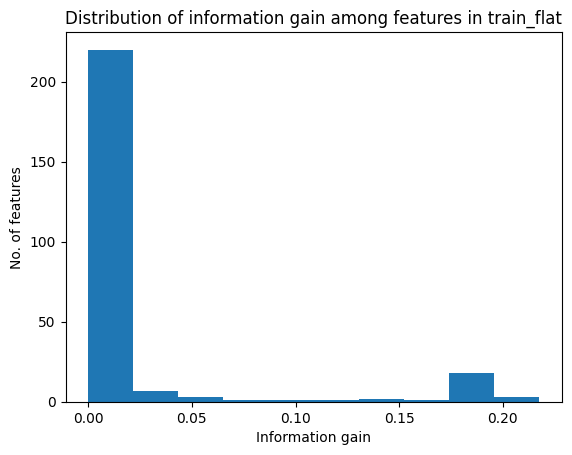

In [21]:
# Visualize 
print("Top 5 columns by information gain:")
print(col_info_gain[:5])
print("Bottom 5 columns by information gain:")
print(col_info_gain[-5:])

# Histogram of Information gain 
fig = plt.hist(col_info_gain)
plt.title("Distribution of information gain among features in train_flat")
plt.xlabel("Information gain")
plt.ylabel("No. of features")
plt.show()

We see that most features provide information gain in the bottom 10% percentile of all information gain scores. We choose to discard these. 

In [22]:
# Subset features
feature_sub_info_gain = list(col_info_gain[col_info_gain >= 0.025].index)
print("No. of features selected on the basis of Information Gain:", len(feature_sub_info_gain))


No. of features selected on the basis of Information Gain: 36


### ANOVA F-value

ANOVA assumes that the data within groups is normally distributed, which is why we first use the Shapiro-Wilk test for normality. We apply it to each feature within each label group. If the Shapiro-Wilk test suggests that all columns are normally distributed, we can consider the ANOVA F-values for feature selection, otherwise we do not. 

c:\shaila\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14680464.
  res = hypotest_fun_out(*samples, **kwds)
c:\shaila\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


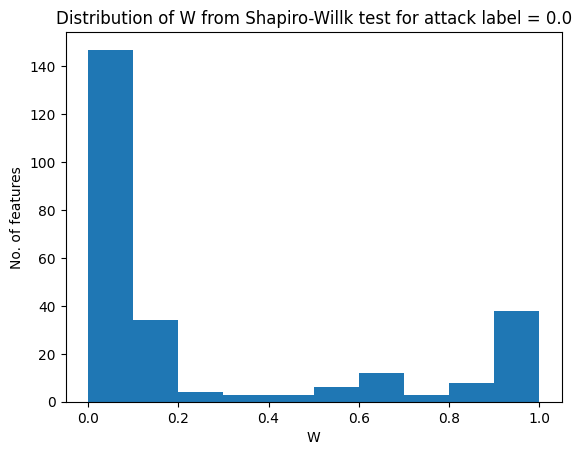

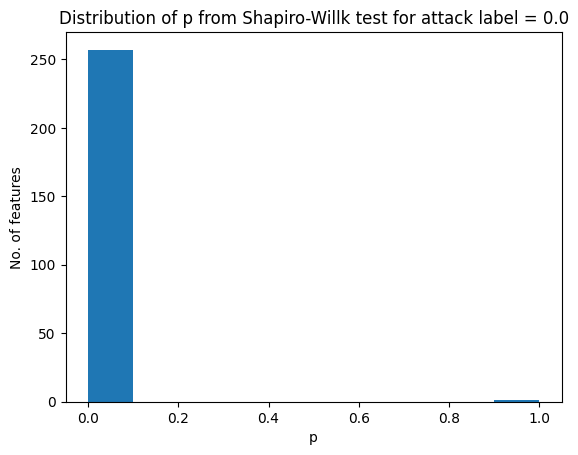

c:\shaila\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 145944.
  res = hypotest_fun_out(*samples, **kwds)


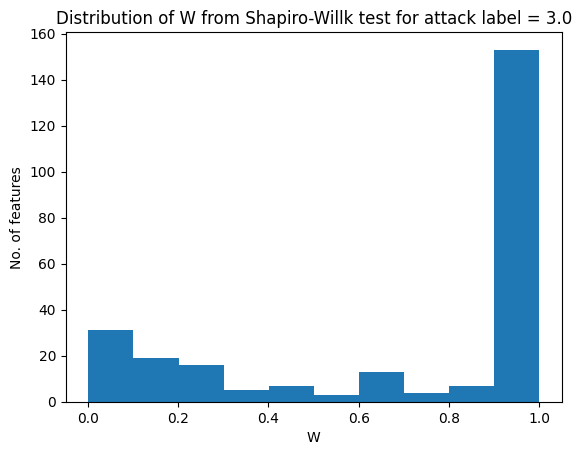

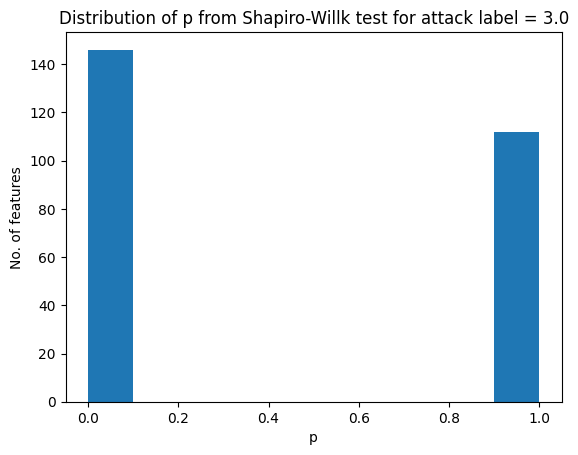

c:\shaila\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11302.
  res = hypotest_fun_out(*samples, **kwds)


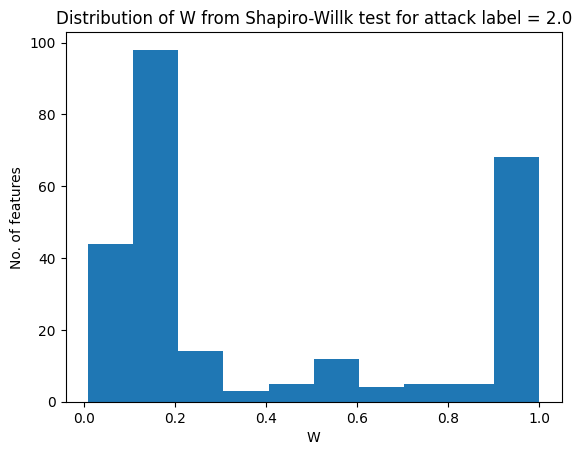

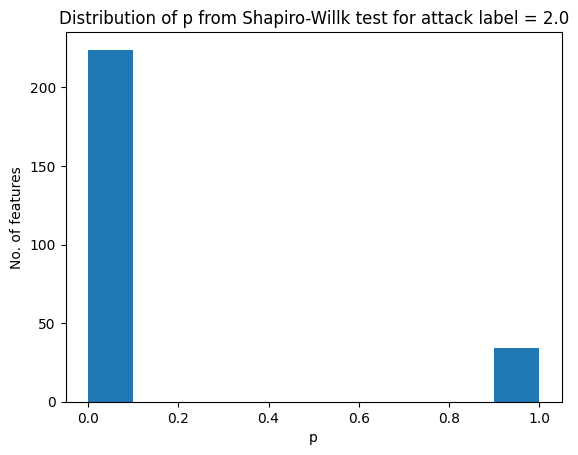

c:\shaila\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12070.
  res = hypotest_fun_out(*samples, **kwds)


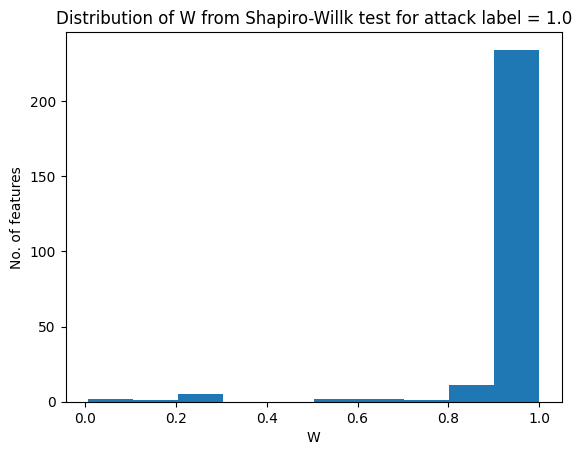

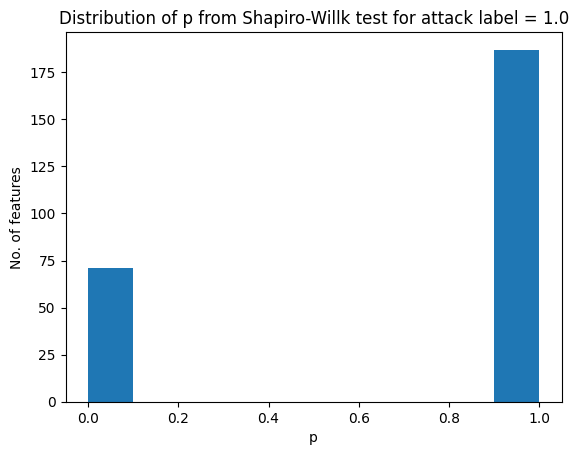

c:\shaila\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 57261.
  res = hypotest_fun_out(*samples, **kwds)


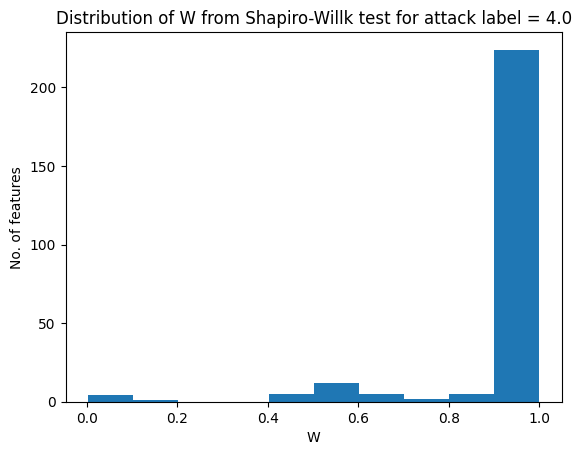

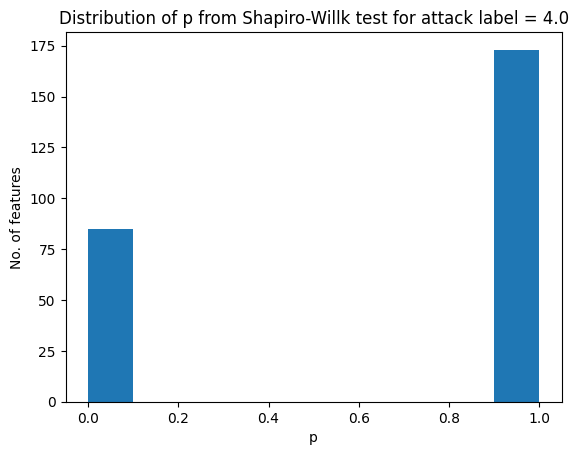

In [23]:
# Test for normality

for label in train_flat_norm.attack.unique():
    df_sub = train_flat_norm[train_flat_norm.attack == label]
    col_shapiro = df_sub.apply(lambda x: shapiro(x), axis=0)

    fig = plt.hist((col_shapiro.iloc[0]))
    plt.title("Distribution of W from Shapiro-Willk test for attack label = " + str(label))
    plt.xlabel("W")
    plt.ylabel("No. of features")
    plt.show()

    fig = plt.hist((col_shapiro.iloc[1]))
    plt.title("Distribution of p from Shapiro-Willk test for attack label = " + str(label))
    plt.xlabel("p")
    plt.ylabel("No. of features")
    plt.show()


Based on the W and p-values of features in each group, we cannot make the generaization that the data is normally distributed in each group. Therefore, we choose to not use the ANOVA f-value for feature selection. 

In [24]:
# Calculate ANOVA F-value
anova_fvalues, anova_pvalues = f_classif(train_flat_norm.drop(columns=['attack']), train_flat_norm.attack)

In [25]:
# Create DataFrame with F-values and p-values for use later
col_anova = pd.DataFrame({'fvalue': anova_fvalues, 'pvalue': anova_pvalues}, index=[col for col in train_flat_norm.columns if col != 'attack'])
col_anova = col_anova.sort_values(by='fvalue', ascending=False)

# Save ANOVA F-values and p-values to disk
with open('col_anova', 'wb') as fp:
    pickle.dump(col_anova, fp)

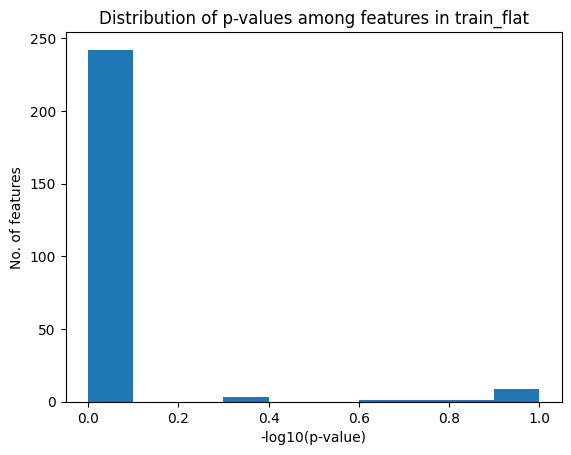

In [26]:
# Visualize p-values 
fig = plt.hist((col_anova.pvalue))
plt.title("Distribution of p-values among features in train_flat")
plt.xlabel("-log10(p-value)")
plt.ylabel("No. of features")
plt.show()

In [27]:
# Retain features with p-values under 0.05
col_anova_sub = col_anova[col_anova.pvalue <= 0.05]
print("No. of features wit p-values <= 0.05:", len(col_anova_sub))
# display(col_anova_sub.head())

No. of features wit p-values <= 0.05: 241


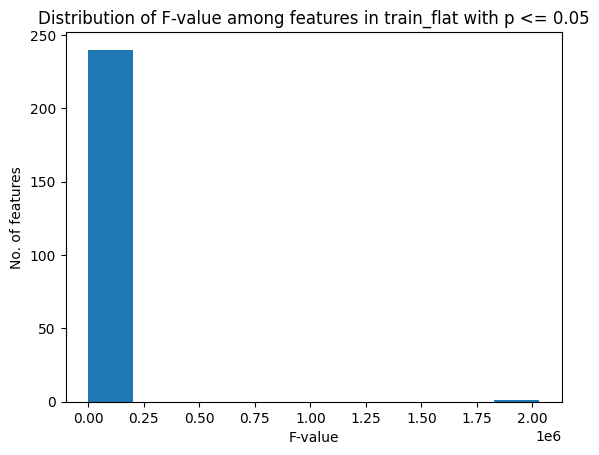

In [28]:
# Distribution of F-values in col_anova_sub
fig = plt.hist((col_anova_sub.fvalue))
plt.title("Distribution of F-value among features in train_flat with p <= 0.05")
plt.xlabel("F-value")
plt.ylabel("No. of features")
plt.show()

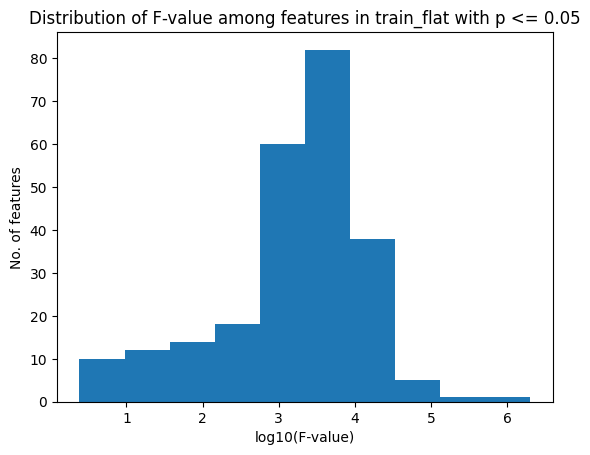

In [29]:
# Distribution of F-values in col_anova_sub (in logoarithm scale)
fig = plt.hist(np.log10(col_anova_sub.fvalue))
plt.title("Distribution of F-value among features in train_flat with p <= 0.05")
plt.xlabel("log10(F-value)")
plt.ylabel("No. of features")
plt.show()

### Pairwise Pearson correlation

We calculate the pairwise Pearson correlation among the features and retain only features that are not strongly correlated with each other (i.e. show absolute correlation coefficient <= 0.99)

In [30]:
# Calculate pairwise Pearson correlation among all feature columns
pearson_corr = train_flat_norm.drop(columns=['attack']).corr(method='pearson')

with open('col_pearson_corr_mat', 'wb') as fp:
    pickle.dump(pearson_corr, fp)

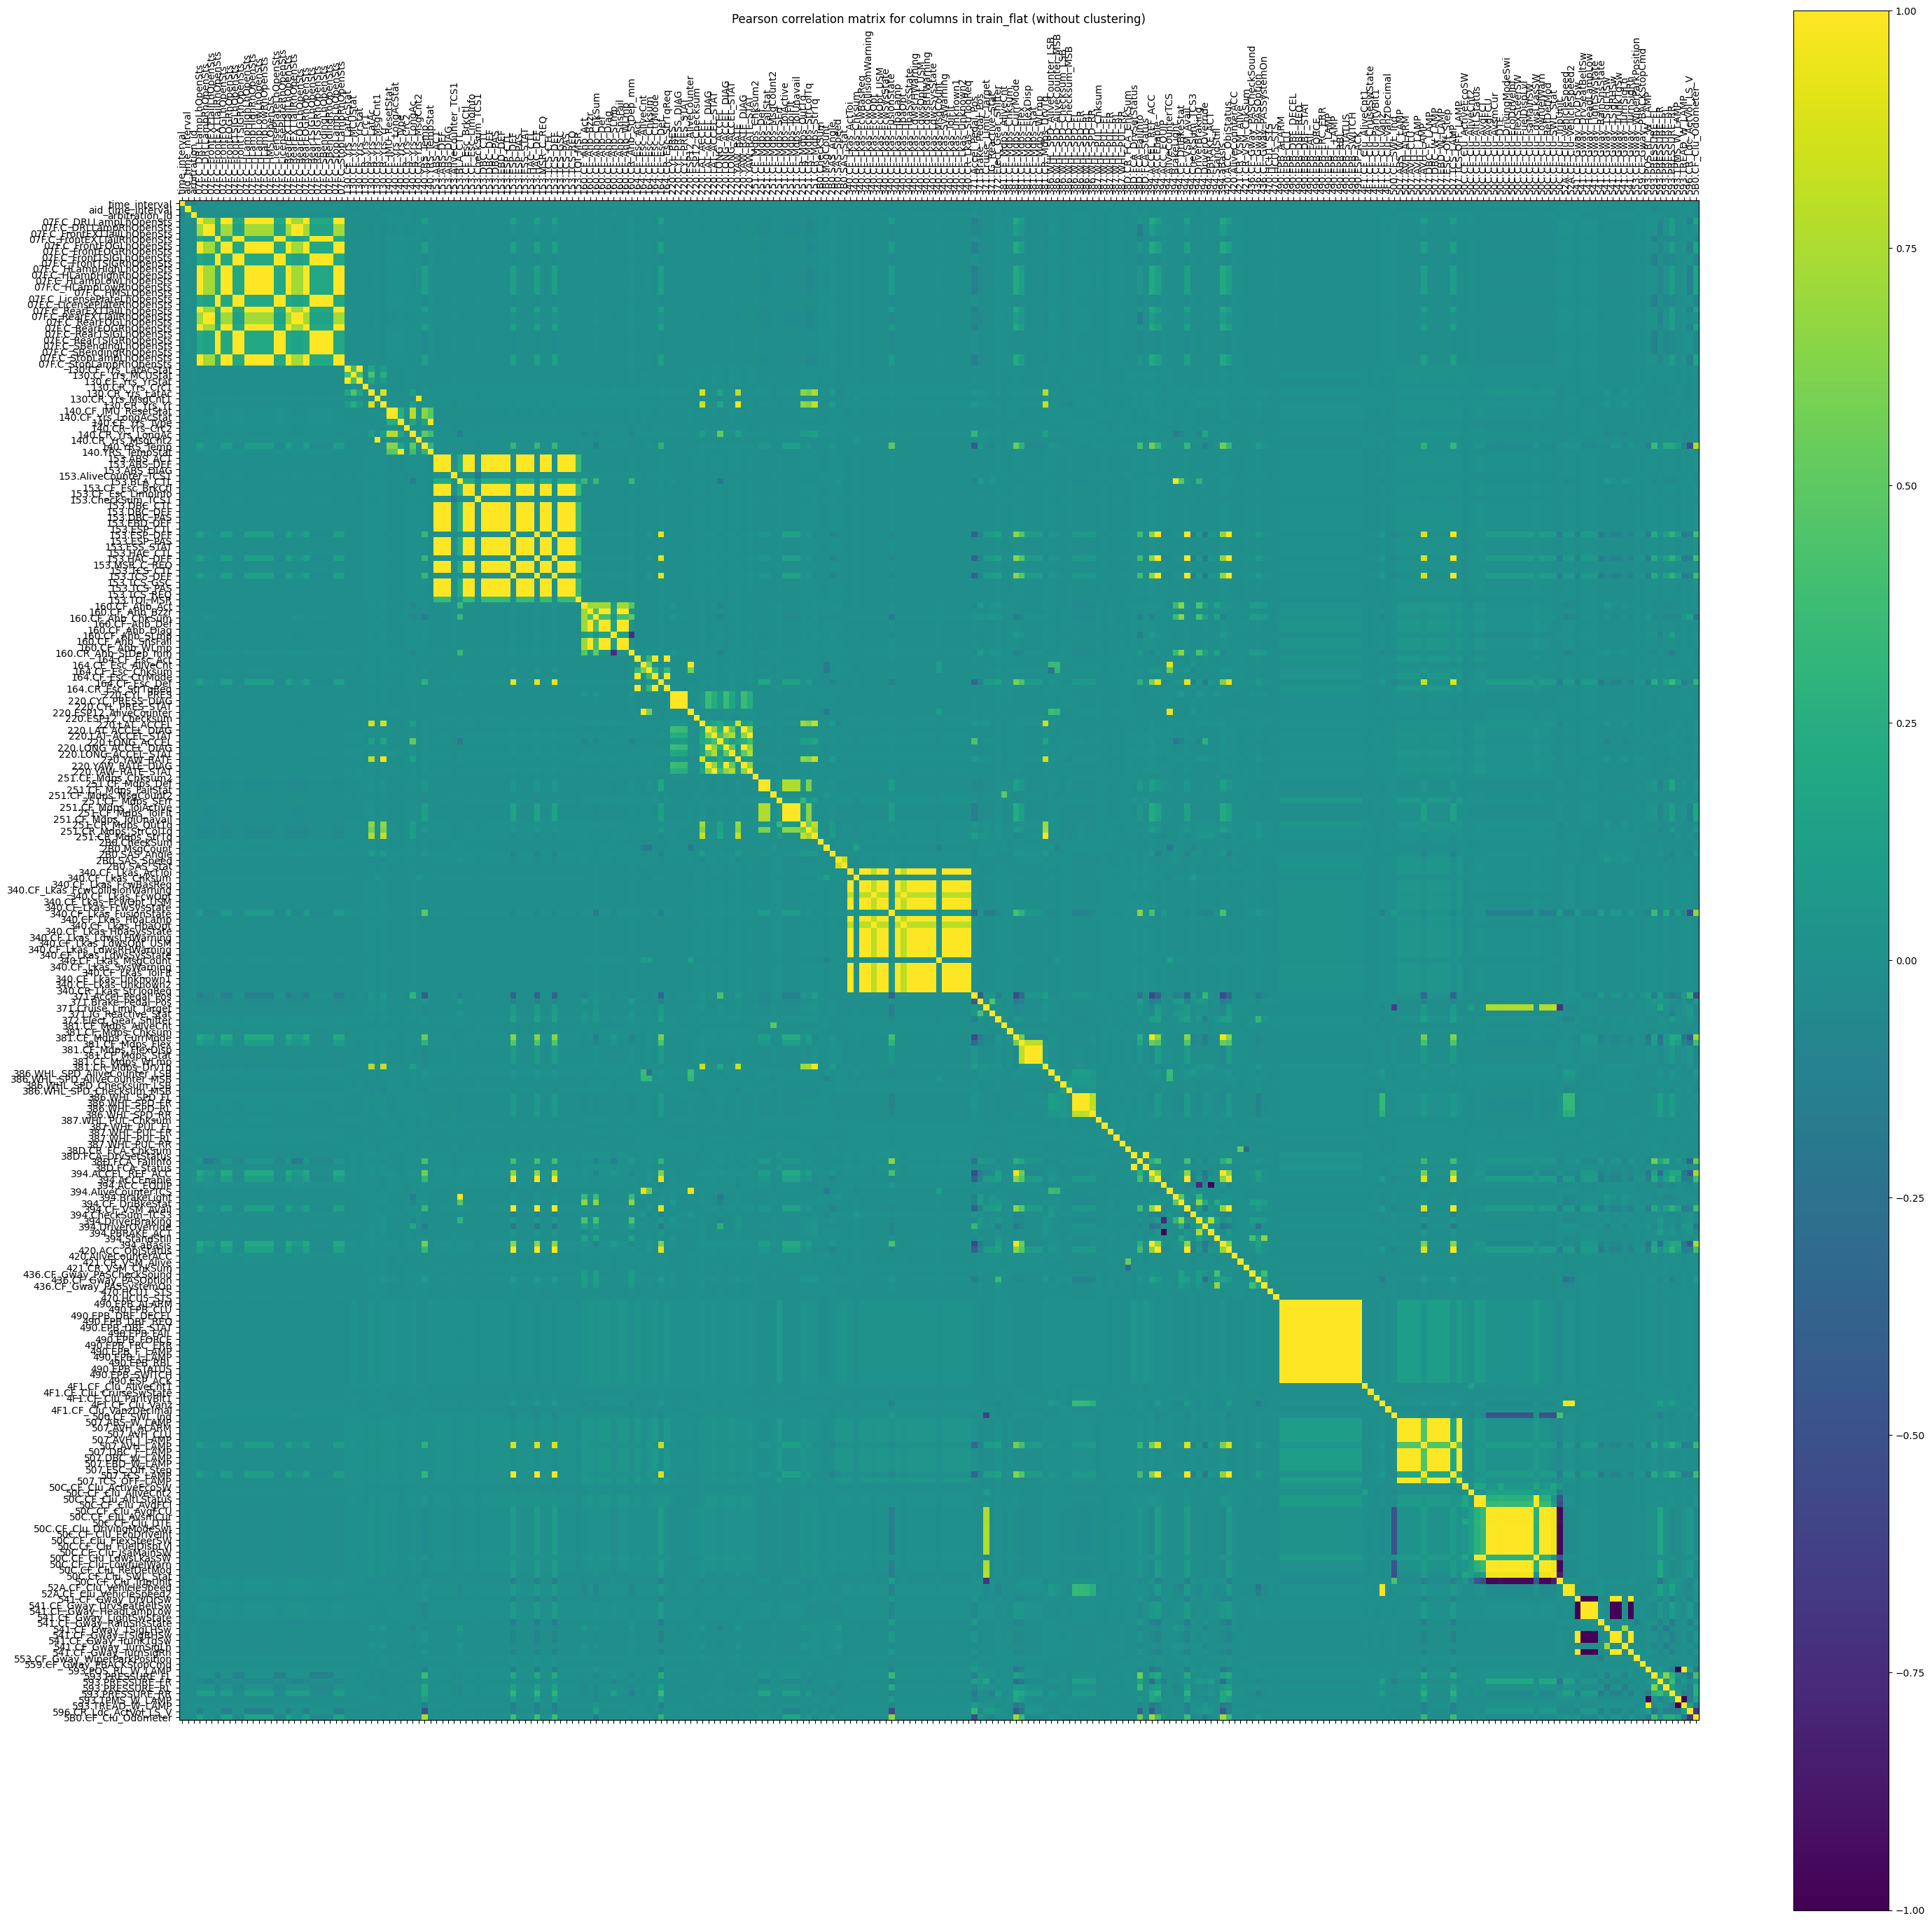

In [31]:
# Visualize correlation matrix
f = plt.figure(figsize=(35, 35))
plt.matshow(pearson_corr, fignum=f.number)
plt.xticks(range(train_flat.select_dtypes(['number']).shape[1]), train_flat.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(train_flat.select_dtypes(['number']).shape[1]), train_flat.select_dtypes(['number']).columns)
cb = plt.colorbar()
plt.title('Pearson correlation matrix for columns in train_flat (without clustering)')
plt.show()

In [32]:
# Identify features that show strong collinearity 

high_corr = set()
for i in range(len(pearson_corr.columns)):
    for j in range(i):
        if abs(pearson_corr.iloc[i, j]) > 0.99:
            high_corr.add(pearson_corr.columns[i])
print("No. of columns showing high correlation to other columns:", len(high_corr))
# print(high_corr)

# Discard features show strong collinearity 
feature_sub_pearson = [feat for feat in train_flat_norm.columns if (feat not in high_corr) and (feat != 'attack')]
print("No. of columns retained from pairwise Pearson correlation tests:", len(feature_sub_pearson))

No. of columns showing high correlation to other columns: 121
No. of columns retained from pairwise Pearson correlation tests: 136


### Feature variance

In [33]:
# Calculate feature variance
variance_selector = VarianceThreshold()
variance_selector.fit(train_flat_norm.drop(columns=['attack']))

VarianceThreshold()

In [34]:
# Convert to indexed Series for use later
col_variance = pd.Series(list(variance_selector.variances_), index=list(variance_selector.feature_names_in_))
col_variance = col_variance.sort_values(ascending=False)

# Save feature variances to disk
with open('col_variance', 'wb') as fp:
    pickle.dump(col_variance, fp)

Top 5 columns by feature variance:    4F1.CF_Clu_ParityBit1    0.250000
164.CF_Esc_Def           0.249800
153.TCS_DEF              0.247177
153.ESP_DEF              0.247177
153.HAC_DEF              0.247177
dtype: float64
Bottom 5 columns by feature variance: 4F1.CF_Clu_CruiseSwState    1.456620e-06
593.PRESSURE_FL             8.578365e-07
593.PRESSURE_RL             3.696949e-07
160.CR_Ahb_StDep_mm         3.239618e-08
5B0.CF_Clu_Odometer         1.543562e-09
dtype: float64


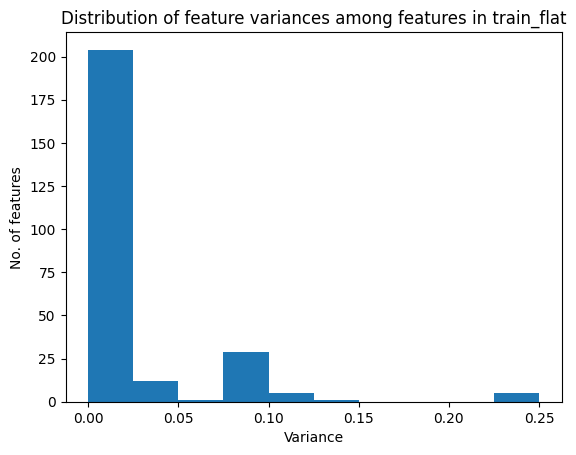

In [35]:
# Visualization
print("Top 5 columns by feature variance:   ", col_variance[:5])
print("Bottom 5 columns by feature variance:", col_variance[-5:])

# Histogram of variance
fig = plt.hist(col_variance)
plt.title("Distribution of feature variances among features in train_flat")
plt.xlabel("Variance")
plt.ylabel("No. of features")
plt.show()

We choose to discard the approximately 200 features that show variance of less than 0.025

In [36]:
# Retain features with high variance
feature_variance = list(col_variance[col_variance >= 0.025].index)
print("No. of features retained on the basis of feature variance:", len(feature_variance))

No. of features retained on the basis of feature variance: 53


### Final feature set

In this section we inspect the feature sets selected from information gain, pairwise pearson correlation tests, and feature variance. 

No. of features retained from information gain         : 36
No. of features retained from pearson correlation tests: 136
No. of features retained from feature variance         : 53


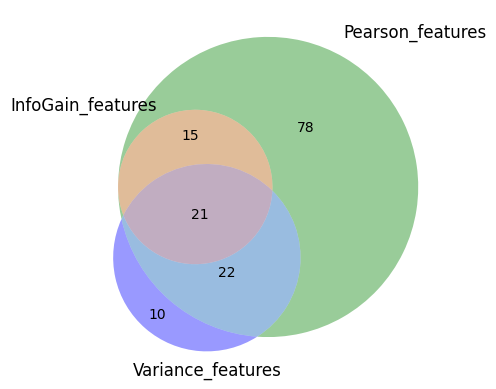

In [37]:
# Visualize feature sets
print("No. of features retained from information gain         :", len(feature_sub_info_gain))
print("No. of features retained from pearson correlation tests:", len(feature_sub_pearson))
print("No. of features retained from feature variance         :", len(feature_variance))

venn3([set(feature_sub_info_gain), set(feature_sub_pearson), set(feature_variance)], ('InfoGain_features', 'Pearson_features', 'Variance_features'))
plt.show()

We consider the features that are present in all three sets as the final feature set. 

In [38]:
# Intersection
final_colnames = set(feature_sub_info_gain).intersection(set(feature_sub_pearson).intersection(set(feature_variance)))

print("No. of features in final feature set:", len(final_colnames))
print("Final feature set:", final_colnames)

# Save final feature set to disk
with open('final_colnames', 'wb') as fp:
    pickle.dump(list(final_colnames), fp)

No. of features in final feature set: 21
Final feature set: {'50C.CF_Clu_AliveCnt2', '394.CheckSum_TCS3', '4F1.CF_Clu_VanzDecimal', '2B0.CheckSum', '2B0.MsgCount', 'arbitration_id', '164.CF_Esc_AliveCnt', '421.CR_VSM_ChkSum', '4F1.CF_Clu_AliveCnt1', '153.CheckSum_TCS1', '420.AliveCounterACC', '340.CF_Lkas_Chksum', '421.CR_VSM_Alive', '340.CF_Lkas_MsgCount', '220.ESP12_AliveCounter', '38D.CR_FCA_ChkSum', '394.AliveCounterTCS', '140.CR_Yrs_MsgCnt2', '153.AliveCounter_TCS1', '220.ESP12_Checksum', '130.CR_Yrs_MsgCnt1'}


In [42]:
# Save individual feature sets
with open('feature_sub_info_gain', 'wb' ) as fp:
    pickle.dump(list(feature_sub_info_gain), fp)

with open('feature_variance', 'wb') as fp:
    pickle.dump(list(feature_variance), fp)

with open('feature_sub_pearson', 'wb') as fp:
    pickle.dump(list(feature_sub_pearson), fp)

## Prepare data for model

We apply the preprocessing steps to each time window and save it as memory-mapped files for fast I/O during training and testing

In [2]:
reload(helper_functions)
from helper_functions import *

def writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, file_name):

    data_count = 0
    mmapped_array = np.memmap("model_data/" + file_name + ".npy", dtype="float", mode="w+", shape=(len(startidx), 150, len(colnames)))

    pbar_count = len(startidx)               # Progress bar setup
    with tqdm(total = pbar_count) as pbar:   # Progress bar
        
        for lname in list(set(lnames)):

            fp = "CSV_Signals_Multiclass/" + lname.rstrip(".log") + ".csv"
            df = pd.read_csv(fp)                            # Read in log

            df = df[[x for x in colnames if x != 'attack']] # Keep only selected columns
            if 'arbitration_id' in colnames:                # If AID is an included feature, convert it to integer
                df['arbitration_id'] = df.arbitration_id.apply(lambda x: int(x, 16))
            df = df.ffill()                                 # Forward-fill and delete NaN rows
            df = minMaxScaleWindowModel(df, minmax_vals)    # Minmax scaling

            indices = [(a,c) for a,b,c in zip(startidx, lnames, labels) if (b == lname) ]     # Get starting indices of all windows in current log
            
            for tup in indices:                     # Each tuple is (start index, window label)
                win = df.iloc[tup[0]:(tup[0]+150)]  # Window starting at tup[0]
                mmapped_array[data_count] = win
                data_count = data_count + 1      

                pbar.update(1)                      # Progress bar update

    mmapped_array.flush()

In [3]:
# with open('final_colnames', 'rb') as fp:
with open('feature_sub_info_gain', 'rb') as fp:
    colnames = pickle.load(fp)
with open('attack_lnames', 'rb')  as fp:    # Attack log names    
    attack_lnames = pickle.load(fp)
with open('minmax_vals', 'rb') as fp:
        minmax_vals = pickle.load(fp)

print("No. of features:", len(colnames))

No. of features: 36


In [4]:
# Training data info
with open('startidx_train', 'rb') as fp:
        startidx = pickle.load(fp)
with open('lnames_train', 'rb') as fp:
    lnames = pickle.load(fp)
with open('labels_train', 'rb') as fp:
    labels = pickle.load(fp)

# Write training data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "train_data")

100%|██████████| 6106345/6106345 [31:13<00:00, 3258.54it/s]  


In [5]:
# Validation data info
with open('startidx_val', 'rb') as fp:
        startidx = pickle.load(fp)
with open('lnames_val', 'rb') as fp:
    lnames = pickle.load(fp)
with open('labels_val', 'rb') as fp:
    labels = pickle.load(fp)

# Write validation data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "val_data")

100%|██████████| 2035450/2035450 [12:05<00:00, 2804.45it/s] 


In [6]:
# Testing data info
with open('startidx_test', 'rb') as fp:
    startidx = pickle.load(fp)
with open('lnames_test', 'rb') as fp:
    lnames = pickle.load(fp)
with open('labels_test', 'rb') as fp:
    labels = pickle.load(fp)

# Write testing data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "test_data")

100%|██████████| 2035450/2035450 [12:00<00:00, 2825.83it/s] 
